# Emotion Detection

## Importing Libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt # to visualaze the model performance
import numpy as np
from glob import glob # to make everything as a list present in the directory
import cv2 # to read and perform actions on images
import random
import os

%matplotlib inline 

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Exploring Dataset

Dataset taken from "Kaggle FER-2013"

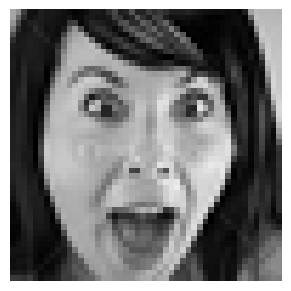

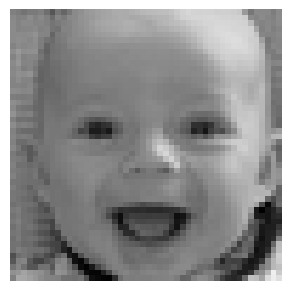

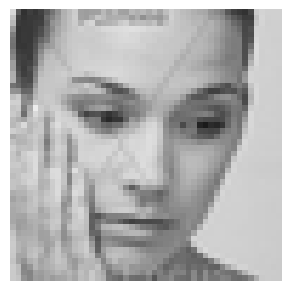

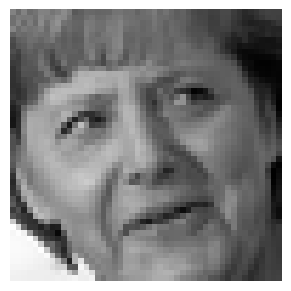

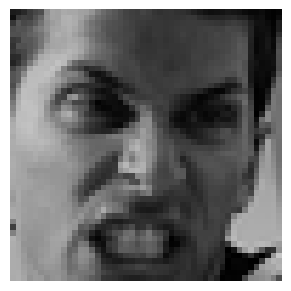

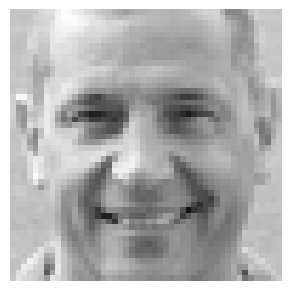

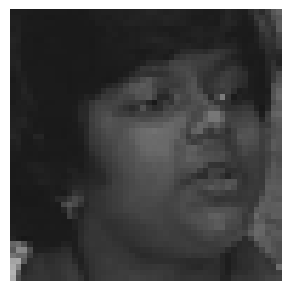

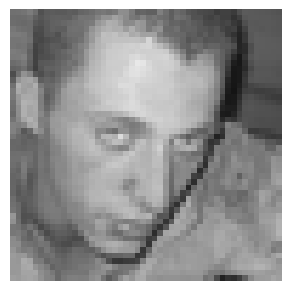

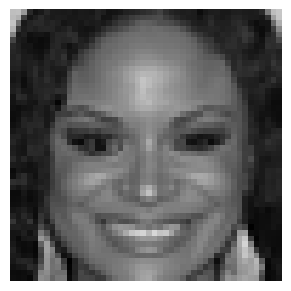

In [22]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize= (12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## Preparing Data for Training

In [23]:
img_size = 48
batch_size = 64 # Hyperparameter any value can be given

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

datagen_test = ImageDataGenerator()
test_generator = datagen_train.flow_from_directory("test/", 
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Defining Model

In [24]:
def convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               padding ="same",)(input_tensor)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size= (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [25]:
def dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [26]:
def model_f(input_shape):
    inputs = Input(input_shape)
    conv_1 = convolution(inputs, 64, (3,3))
    conv_2 = convolution(conv_1, 128, (5,5))
    conv_3 = convolution(conv_2, 512, (3,3))
    conv_4 = convolution(conv_3, 512, (3,3))

    flatten = Flatten()(conv_4)

    dense_1 = dense_f(flatten,256)
    dense_2 = dense_f(dense_1,512)
    
    output = Dense(7, activation="softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(learning_rate = 0.0005)
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ['accuracy'])

    return model

In [27]:
model = model_f((48,48,1))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     1,179,90

 Total params: 4,343,303 (16.57 MB)

 Trainable params: 4,340,359 (16.56 MB)

 Non-trainable params: 2,944 (11.50 KB)

## Initilizing the Model

In [28]:
epochs = 15
steps_per_epoch = train_generator.n// train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,patience = 2, min_lr = 0.0001)
callbacks = [checkpoint, reduce_lr]

## Training the Model

In [29]:
history = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_steps,
                    callbacks=callbacks)

Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.2959 - loss: 1.8853
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 227s 490ms/step - accuracy: 0.2960 - loss: 1.8849 - val_accuracy: 0.4129 - val_loss: 1.5141 - learning_rate: 5.0000e-04
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:38 354ms/step - accuracy: 0.4062 - loss: 1.5213
Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - accuracy: 0.4062 - loss: 1.5213 - val_accuracy: 0.9000 - val_loss: 0.9286 - learning_rate: 5.0000e-04
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.4565 - loss: 1.4216
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 245s 546ms/step - accuracy: 0.4566 - loss: 1.4215 - val_accuracy: 0.4619 - val_loss: 1.3777 - learning_rate: 5.0000e-04
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:04 547ms/step - accuracy: 0.4531 - loss: 1.5041
Epoch 4: saving model to model_weights.weights.h5

## Model Evaluation

In [30]:
model.evaluate(test_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.6118 - loss: 1.0624


[1.053683876991272, 0.6103371381759644]

## Plotting Loss

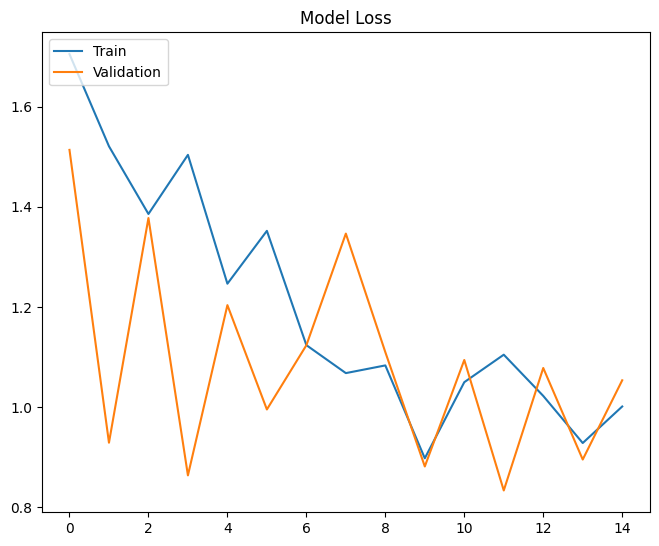

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom= 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace=0.35)

## Plotting Model Accuracy

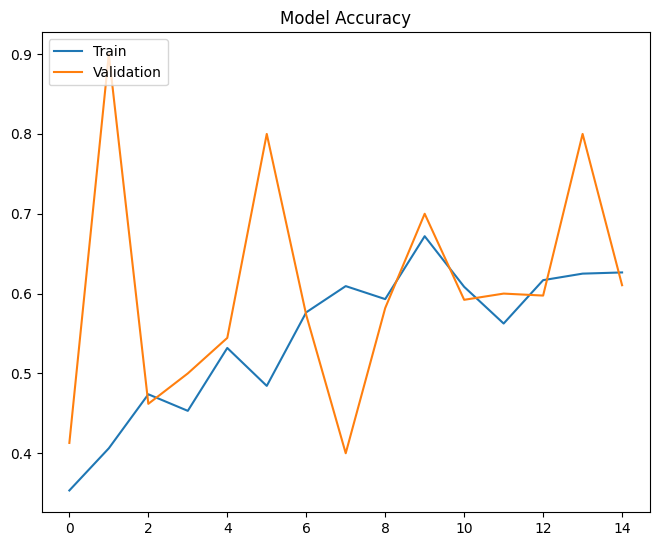

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom= 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace=0.35)

## Saving Model

In [33]:
model_json = model.to_json()
with open('model_a.json', 'w') as json_file:
    json_file.write(model_json)